In [2]:
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import csv
from Bio.SeqRecord import SeqRecord
import torch
import json
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler

In [22]:
# len = 1259; max4911; min54
fasta_pos = "training/human_train_positive.fasta"
with open(fasta_pos, "r") as file1:
    sequences_pos = list(SeqIO.parse(file1, "fasta"))

sequence_data = []
for seq_record in sequences_pos:
    sequence_data.append({"Sequence": str(seq_record.seq),"Label":1})
df_tra_pos = pd.DataFrame(sequence_data)
    
fasta_neg = "training/human_train_negative.fasta"
with open(fasta_neg, "r") as file2:
    sequences_neg = list(SeqIO.parse(file2, "fasta"))

sequence_data = []
for seq_record in sequences_neg:
    sequence_data.append({"Sequence": str(seq_record.seq),"Label":0})
df_tra_neg = pd.DataFrame(sequence_data)

training = pd.concat([df_tra_pos, df_tra_neg], ignore_index=True)

In [23]:
# len = 315
fasta_pos_test = "testing/human_test_positive.fasta"
with open(fasta_pos_test, "r") as file3:
    sequences_pos_test = list(SeqIO.parse(file3, "fasta"))

sequence_data = []
for seq_record in sequences_pos_test:
    sequence_data.append({"Sequence": str(seq_record.seq),"Label":1})
df_test_pos = pd.DataFrame(sequence_data)
    
fasta_neg_test = "testing/human_test_negative.fasta"
with open(fasta_neg_test, "r") as file4:
    sequences_neg_test = list(SeqIO.parse(file4, "fasta"))
    
sequence_data = []
for seq_record in sequences_neg_test:
    sequence_data.append({"Sequence": str(seq_record.seq),"Label":0})
df_test_neg = pd.DataFrame(sequence_data)

testing = pd.concat([df_test_pos, df_test_neg], ignore_index=True)

In [12]:
testing

,Sequence,Label
0,MAELKSLSGDAYLALSHGYAAAAAGLAYGAAREPEAARGYGTPGPG...,1
1,MPDPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSIYVYKVL...,1
2,MYQSLALAASPRQAAYADSGSFLHAPGAGSPMFVPPARVPSMLSYL...,1
3,MNMEGLVMFQDLSIDFSQEEWECLDAAQKDLYRDVMMENYSSLVSL...,1
4,MTRSCSAVGCSTRDTVLSRERGLSFHQFPTDTIQRSKWIRAVNRVD...,1
...,...,...
625,MPLAQLADPWQKMAVESPSDSAENGQQIMDEPMGEEEINPQTEEVS...,0
626,MAILMLSLQLILLLIPSISHEAHKTSLSSWKHDQDWANVSNMTFSN...,0
627,MAQASPPRPERVLGASSPEARPAQEALLLPTGVFQVAEKMEKRTCA...,0
628,MGKSEGPVGMVESAGRAGQKRPGFLEGGLLLLLLLVTAALVALGVL...,0


In [13]:
training

,Sequence,Label
0,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,1
1,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,1
2,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,1
3,MARVGPGRAGVSCQGRGRGRGGSGQRRPPTWEISDSDAEDSAGSEA...,1
4,MAAADGGGPGGASVGTEEDGGGVGHRTVYLFDRREKESELGDRPLQ...,1
...,...,...
2513,MEQGKGLAVLILAIILLQGTLAQSIKGNHLVKVYDYQEDGSVLLTC...,0
2514,MARGPGLAPPPLRLPLLLLVLAAVTGHTAAQDNCTCPTNKMTVCSP...,0
2515,MELSWHVVFIALLSFSCWGSDWESDRNFISTAGPLTNDLLHNLSGL...,0
2516,MWCIVLFSLLAWVYAEPTMYGEILSPNYPQAYPSEVEKSWDIEVPE...,0


In [14]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = AutoModel.from_pretrained("Rostlab/prot_bert")

2023-11-23 12:38:05.570574: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 12:38:05.572568: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 12:38:05.597295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 12:38:05.597312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 12:38:05.598088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def encode_sequences(sequences):
    return [tokenizer.encode(sequence, add_special_tokens=True) for sequence in sequences]

def embed_sequences(encoded_sequences):
    input_ids = torch.tensor(encoded_sequences)
    with torch.no_grad():
        embeddings = model(input_ids)
    return embeddings

def dimention_reduction(embeddings_def):
    dimention_reduction_result = []
    for i in range(1024):
        dimention_reduction_result.append(np.mean(embeddings_def[:,i].tolist()))
    return dimention_reduction_result

In [10]:
#feature = pd.DataFrame([dimention_reduction(embeddings[1])])
for n in range(len(training['Sequence'])):
    print(n)
    if n == 0:
        sequences = training['Sequence'][n]
        encoded_sequences = encode_sequences(sequences)
        embeddings = embed_sequences(encoded_sequences)
        feature_temp = {
            '0': dimention_reduction(embeddings[1])
        }
        feature = pd.DataFrame.from_dict(feature_temp, orient='index')
    else:
        sequences = training['Sequence'][n]
        encoded_sequences = encode_sequences(sequences)
        embeddings = embed_sequences(encoded_sequences)
        feature.loc[n] = dimention_reduction(embeddings[1])
feature.to_csv('feature.csv', index=False)

0
1
2
3
4
5
6
7
8
9


In [11]:
feature

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.208095,0.220136,-0.197749,-0.210119,-0.225618,-0.220520,-0.218668,-0.216284,0.202559,-0.212885,...,0.213570,-0.205959,0.218051,-0.216005,-0.214326,-0.200823,0.206391,0.209501,0.195413,-0.214074
1,-0.209904,0.222026,-0.199485,-0.211941,-0.227543,-0.222412,-0.220548,-0.218148,0.204329,-0.214726,...,0.215416,-0.207753,0.219927,-0.217867,-0.216176,-0.202581,0.208188,0.211319,0.197132,-0.215923
2,-0.210550,0.222705,-0.200102,-0.212593,-0.228237,-0.223093,-0.221223,-0.218817,0.204959,-0.215386,...,0.216077,-0.208393,0.220600,-0.218535,-0.216839,-0.203207,0.208829,0.211969,0.197743,-0.216585
3,-0.207671,0.219691,-0.197343,-0.209691,-0.225164,-0.220075,-0.218226,-0.215846,0.202144,-0.212453,...,0.213137,-0.205539,0.217610,-0.215567,-0.213890,-0.200411,0.205970,0.209074,0.195011,-0.213639
4,-0.208217,0.220262,-0.197866,-0.210241,-0.225746,-0.220647,-0.218794,-0.216409,0.202678,-0.213009,...,0.213694,-0.206080,0.218176,-0.216129,-0.214450,-0.200942,0.206512,0.209623,0.195529,-0.214198
5,-0.205446,0.217365,-0.195209,-0.207449,-0.222792,-0.217745,-0.215912,-0.213552,0.199967,-0.210187,...,0.210865,-0.203332,0.215300,-0.213275,-0.211613,-0.198250,0.203760,0.206837,0.192898,-0.211363
6,-0.215458,0.227839,-0.204807,-0.217539,-0.233471,-0.228234,-0.226330,-0.223880,0.209760,-0.220384,...,0.221089,-0.213260,0.225696,-0.223592,-0.221865,-0.207973,0.213704,0.216904,0.202402,-0.221607
7,-0.207726,0.219749,-0.197395,-0.209746,-0.225223,-0.220133,-0.218284,-0.215903,0.202198,-0.212509,...,0.213193,-0.205593,0.217667,-0.215624,-0.213947,-0.200465,0.206025,0.209130,0.195063,-0.213696
8,-0.205904,0.217842,-0.195648,-0.207909,-0.223279,-0.218224,-0.216387,-0.214023,0.200415,-0.210652,...,0.211332,-0.203786,0.215774,-0.213746,-0.212081,-0.198695,0.204214,0.207297,0.193333,-0.211831
9,-0.206906,0.218890,-0.196610,-0.208919,-0.224346,-0.219273,-0.217429,-0.215056,0.201396,-0.211673,...,0.212355,-0.204780,0.216814,-0.214778,-0.213107,-0.199669,0.205210,0.208305,0.194285,-0.212856


In [12]:
#feature.to_csv('feature.csv', index=False)

In [20]:
training_feature = pd.read_csv("Protein_Bert/feature_train.csv")
training_feature

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.208095,0.220136,-0.197749,-0.210119,-0.225618,-0.220520,-0.218668,-0.216284,0.202558,-0.212885,...,0.213570,-0.205959,0.218051,-0.216005,-0.214325,-0.200823,0.206391,0.209501,0.195413,-0.214074
1,-0.209904,0.222025,-0.199485,-0.211941,-0.227543,-0.222412,-0.220548,-0.218148,0.204329,-0.214726,...,0.215416,-0.207753,0.219927,-0.217867,-0.216176,-0.202581,0.208188,0.211319,0.197132,-0.215923
2,-0.210550,0.222705,-0.200102,-0.212592,-0.228237,-0.223093,-0.221223,-0.218817,0.204959,-0.215386,...,0.216077,-0.208393,0.220600,-0.218535,-0.216839,-0.203207,0.208829,0.211969,0.197742,-0.216585
3,-0.207671,0.219691,-0.197343,-0.209691,-0.225164,-0.220075,-0.218226,-0.215846,0.202144,-0.212453,...,0.213137,-0.205539,0.217610,-0.215567,-0.213890,-0.200411,0.205970,0.209074,0.195011,-0.213639
4,-0.208217,0.220262,-0.197866,-0.210241,-0.225746,-0.220647,-0.218794,-0.216409,0.202678,-0.213009,...,0.213694,-0.206080,0.218176,-0.216129,-0.214450,-0.200942,0.206512,0.209623,0.195529,-0.214197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,-0.207851,0.219878,-0.197517,-0.209872,-0.225354,-0.220262,-0.218412,-0.216031,0.202321,-0.212636,...,0.213320,-0.205718,0.217796,-0.215752,-0.214074,-0.200587,0.206149,0.209255,0.195183,-0.213823
2514,-0.209156,0.221244,-0.198767,-0.211187,-0.226747,-0.221630,-0.219771,-0.217377,0.203596,-0.213965,...,0.214653,-0.207011,0.219151,-0.217097,-0.215411,-0.201854,0.207445,0.210567,0.196421,-0.215158
2515,-0.207422,0.219431,-0.197104,-0.209440,-0.224898,-0.219814,-0.217967,-0.215589,0.201900,-0.212199,...,0.212882,-0.205292,0.217351,-0.215310,-0.213636,-0.200170,0.205722,0.208824,0.194774,-0.213384
2516,-0.209384,0.221483,-0.198985,-0.211417,-0.226991,-0.221869,-0.220009,-0.217613,0.203819,-0.214197,...,0.214886,-0.207237,0.219388,-0.217332,-0.215644,-0.202075,0.207671,0.210796,0.196637,-0.215392


In [24]:
scaler1 = StandardScaler()
scaled_data_train = scaler1.fit_transform(training_feature)
training_f = pd.DataFrame(scaled_data_train, columns=training_feature.columns)
training_f['Label'] = training['Label'].tolist()

In [25]:
training_f

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Label
0,0.142026,-0.141646,0.142295,0.141950,0.141484,0.141624,0.141685,0.141779,-0.142179,0.141864,...,0.142085,-0.141725,0.141758,0.141802,0.142233,-0.142077,-0.141971,-0.142396,0.141845,1
1,-0.633506,0.632739,-0.634142,-0.633377,-0.632376,-0.632705,-0.632830,-0.632982,0.633850,-0.633205,...,-0.633636,0.632868,-0.632998,-0.633110,-0.633964,0.633610,0.633421,0.634288,-0.633129,1
2,-0.910533,0.911084,-0.910060,-0.910622,-0.911326,-0.911112,-0.911002,-0.910920,0.910289,-0.910747,...,-0.910447,0.910999,-0.910886,-0.910794,-0.910216,0.910459,0.910594,0.909981,-0.910808,1
3,0.323948,-0.323956,0.323982,0.323964,0.323952,0.323959,0.323960,0.323936,-0.323956,0.323967,...,0.323949,-0.323945,0.323969,0.323978,0.323962,-0.323949,-0.323956,-0.323955,0.323946,1
4,0.089887,-0.089922,0.089820,0.089879,0.089937,0.089922,0.089904,0.089926,-0.089866,0.089886,...,0.089880,-0.089925,0.089889,0.089872,0.089857,-0.089885,-0.089884,-0.089850,0.089912,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,0.246673,-0.247227,0.246238,0.246769,0.247467,0.247252,0.247152,0.247045,-0.246441,0.246896,...,0.246588,-0.247124,0.247038,0.246958,0.246364,-0.246600,-0.246747,-0.246134,0.246941,0
2514,-0.312748,0.312512,-0.312949,-0.312712,-0.312407,-0.312498,-0.312545,-0.312585,0.312850,-0.312654,...,-0.312787,0.312547,-0.312597,-0.312634,-0.312881,0.312780,0.312720,0.312982,-0.312628,0
2515,0.430737,-0.430678,0.430801,0.430734,0.430644,0.430684,0.430688,0.430699,-0.430767,0.430718,...,0.430749,-0.430689,0.430709,0.430716,0.430774,-0.430748,-0.430733,-0.430798,0.430706,0
2516,-0.410483,0.410510,-0.410472,-0.410489,-0.410522,-0.410509,-0.410509,-0.410497,0.410479,-0.410498,...,-0.410482,0.410500,-0.410504,-0.410505,-0.410476,0.410481,0.410487,0.410462,-0.410494,0


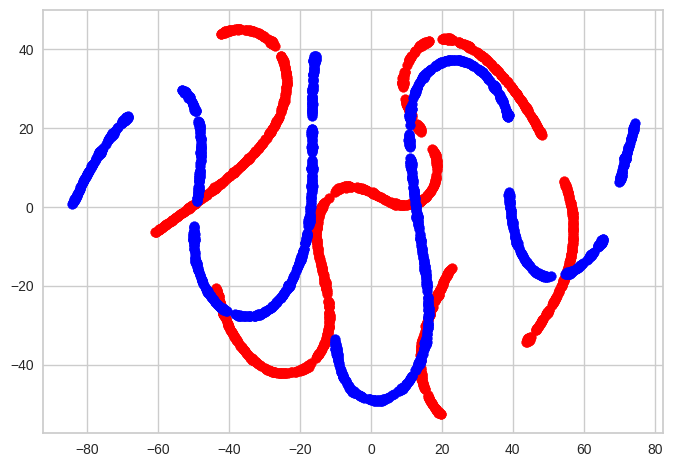

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, n_iter=1000)
X_tsne_1 = tsne.fit_transform(training_f[training_f['Label'] == 1])
X_tsne_0 = tsne.fit_transform(training_f[training_f['Label'] == 0])

plt.scatter(X_tsne_1[:, 0], X_tsne_1[:, 1], color = "red")
plt.scatter(X_tsne_0[:, 0], X_tsne_0[:, 1], color = "blue")
plt.show()

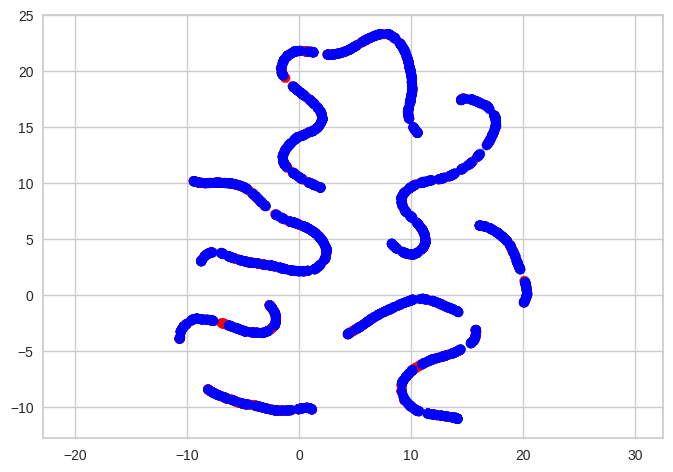

In [84]:
import umap
reducer = umap.UMAP()
train_fea = training_f.drop("Label",axis = 1)
embedding = reducer.fit_transform(train_fea)
#embedding = reducer.fit_transform(training_f)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=['blue' if label == 0 else 'red' for label in training_f['Label']])
plt.gca().set_aspect('equal', 'datalim')

RangeIndex(start=0, stop=50, step=1)


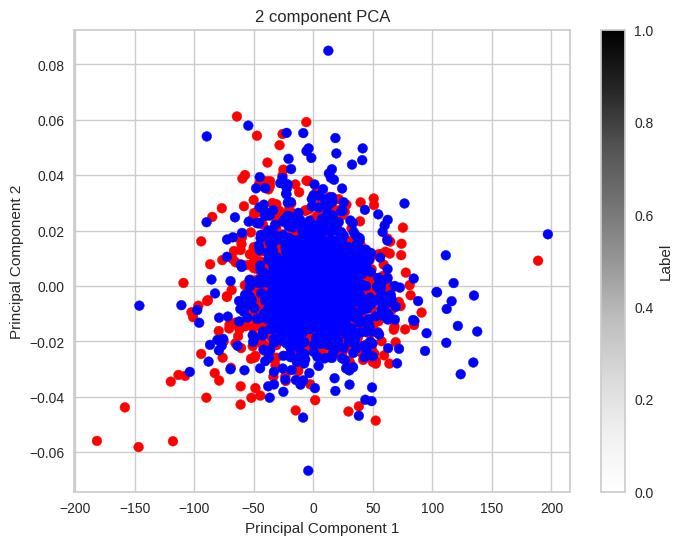

In [67]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def plot_pca(df, target_column):
    """
    Perform PCA on the given dataframe and plot the first two principal components.

    Args:
    df (pd.DataFrame): DataFrame containing the features and target.
    target_column (str): Name of the column in df which contains the target labels.

    Returns:
    None: This function plots the PCA components.
    """
    df = training_f
    target_column = "Label"
    # Separating out the features and target
    features = df.drop(target_column, axis=1)
    target = df[target_column]

    # Performing PCA
    pca = PCA(n_components=50)
    principal_components = pca.fit_transform(features)

    # Creating a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components)
    #print(pca_df.loc[:,0])
    print(pca_df.columns)
    colors = ['blue' if t == 0 else 'red' for t in target]

    # Plotting
    plt.figure(figsize=(8,6))
    plt.scatter(pca_df.loc[:,0], pca_df.loc[:,1], c=colors)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2 component PCA')
    plt.colorbar(label=target_column)
    plt.show()

# Example usage:
# Assuming you have a DataFrame 'dataframe' with a target column 'Label'
plot_pca(training_f, 'Label')


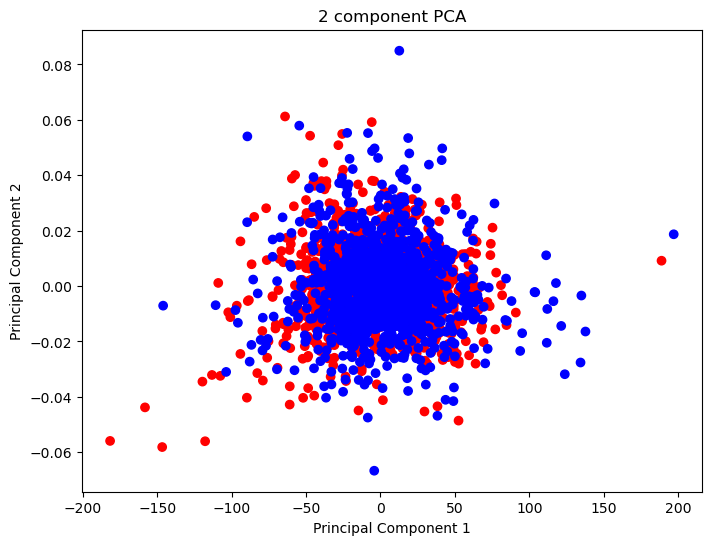

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def plot_pca(df, target_column):
    """
    Perform PCA on the given dataframe and compute the first 50 principal components,
    but plot only the first two principal components.

    Args:
    df (pd.DataFrame): DataFrame containing the features and target.
    target_column (str): Name of the column in df which contains the target labels.

    Returns:
    None: This function plots the PCA components.
    """
    # Separating out the features and target
    features = df.drop(target_column, axis=1)
    target = df[target_column]

    # Performing PCA for 50 components
    pca = PCA(n_components=50)
    principal_components = pca.fit_transform(features)

    # Creating a DataFrame with the first two principal components
    pca_df = pd.DataFrame(data=principal_components[:, :2], columns=['PC1', 'PC2'])

    # Assigning colors based on the target variable
    colors = ['blue' if t == 0 else 'red' for t in target]

    # Plotting the first two components
    plt.figure(figsize=(8,6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c=colors)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2 component PCA')
    plt.show()
    
plot_pca(training_f, 'Label')

In [21]:
testing_feature = pd.read_csv("Protein_Bert/feature_test.csv")
scaler2 = StandardScaler()
scaled_data_test = scaler2.fit_transform(testing_feature)
testing_f = pd.DataFrame(scaled_data_test, columns=testing_feature.columns)
testing_f['Label'] = testing['Label'].tolist()
testing_f.index = pd.RangeIndex(start=2518, stop=3148)
testing_f

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Label
2518,-0.057330,0.057044,-0.057499,-0.057257,-0.056927,-0.057027,-0.057068,-0.057163,0.057432,-0.057189,...,-0.057367,0.057110,-0.057115,-0.057140,-0.057468,0.057369,0.057284,0.057597,-0.057203,1
2519,-1.689691,1.691496,-1.688367,-1.690040,-1.692299,-1.691579,-1.691299,-1.690870,1.688948,-1.690440,...,-1.689400,1.691133,-1.690939,-1.690721,-1.688677,1.689461,1.689934,1.687923,-1.690551,1
2520,0.541338,-0.541178,0.541493,0.541324,0.541109,0.541174,0.541211,0.541215,-0.541411,0.541290,...,0.541366,-0.541204,0.541249,0.541280,0.541436,-0.541356,-0.541322,-0.541495,0.541253,1
2521,-0.443527,0.442689,-0.444184,-0.443384,-0.442306,-0.442657,-0.442783,-0.442972,0.443882,-0.443195,...,-0.443669,0.442851,-0.442965,-0.443072,-0.444016,0.443640,0.443426,0.444366,-0.443123,1
2522,0.199417,-0.199673,0.199209,0.199461,0.199786,0.199689,0.199637,0.199599,-0.199307,0.199518,...,0.199379,-0.199632,0.199586,0.199545,0.199275,-0.199387,-0.199450,-0.199166,0.199545,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3143,-0.042451,0.042811,-0.042192,-0.042521,-0.042977,-0.042822,-0.042777,-0.042678,0.042299,-0.042603,...,-0.042390,0.042737,-0.042704,-0.042665,-0.042248,0.042398,0.042500,0.042092,-0.042619,0
3144,1.496922,-1.497555,1.496425,1.497029,1.497837,1.497570,1.497478,1.497338,-1.496649,1.497172,...,1.496815,-1.497429,1.497351,1.497263,1.496566,-1.496823,-1.497005,-1.496288,1.497226,0
3145,-1.132691,1.132332,-1.132968,-1.132626,-1.132171,-1.132315,-1.132378,-1.132454,1.132843,-1.132547,...,-1.132750,1.132401,-1.132452,-1.132502,-1.132894,1.132737,1.132644,1.133042,-1.132519,0
3146,0.132084,-0.132016,0.132159,0.132080,0.131976,0.132020,0.132023,0.132041,-0.132119,0.132062,...,0.132100,-0.132026,0.132047,0.132057,0.132133,-0.132097,-0.132083,-0.132164,0.132051,0


In [81]:
reducer = umap.UMAP()
train_fea = training_f.drop("Label",axis = 1)
embedding_tra = pd.DataFrame(reducer.fit_transform(train_fea))
embedding_tra['Label'] = training_f['Label'].tolist()


In [11]:
def scale_data(train_data, test_data):
    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    return pd.DataFrame(scaled_train_data, columns=train_data.columns), pd.DataFrame(scaled_test_data, columns=test_data.columns)
 

In [12]:
label_data_train = pd.read_csv("df_train_feature_pb.csv", index_col=None)
label_data_test = pd.read_csv("df_test_feature_pb.csv", index_col=None)

In [13]:
training_feature = pd.read_csv("Protein_Bert/feature_train.csv")
testing_feature = pd.read_csv("Protein_Bert/feature_test.csv")

In [14]:
scaled_X_train, scaled_X_test = scale_data(training_feature, testing_feature)

In [15]:
scaled_X_train['Label'] = label_data_train['Label']
scaled_X_test['Label'] = label_data_test['Label']

In [17]:
scaled_X_test.index = pd.RangeIndex(start=2518, stop=3148)

In [18]:
from pycaret.classification import *
s=setup(data=scaled_X_train, target='Label',test_data=scaled_X_test, fold = 5)

,Description,Value
0,Session id,6080
1,Target,Label
2,Target type,Binary
3,Original data shape,"(3148, 1025)"
4,Transformed data shape,"(3148, 1025)"
5,Transformed train set shape,"(2518, 1025)"
6,Transformed test set shape,"(630, 1025)"
7,Numeric features,1024
8,Preprocess,True
9,Imputation type,simple


In [19]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:49:44
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.5775,0.6056,0.5624,0.5800,0.5709,0.1549,0.1551,0.9320
ridge,Ridge Classifier,0.5207,0.0000,0.5203,0.5202,0.5200,0.0414,0.0414,0.1160
gbc,Gradient Boosting Classifier,0.5203,0.5174,0.4043,0.5260,0.4565,0.0405,0.0416,11.0120
lr,Logistic Regression,0.5199,0.5296,0.5203,0.5193,0.5196,0.0398,0.0398,0.4680
svm,SVM - Linear Kernel,0.5187,0.0000,0.5012,0.5198,0.5101,0.0373,0.0374,0.1240
xgboost,Extreme Gradient Boosting,0.5163,0.5268,0.5075,0.5165,0.5117,0.0325,0.0326,4.4180
nb,Naive Bayes,0.5155,0.5085,0.4074,0.5190,0.4549,0.0309,0.0316,0.3860
knn,K Neighbors Classifier,0.5147,0.5168,0.5258,0.5144,0.5200,0.0294,0.0294,0.7760
ada,Ada Boost Classifier,0.5127,0.5194,0.3939,0.5155,0.4430,0.0253,0.0258,2.0740
qda,Quadratic Discriminant Analysis,0.5091,0.5091,0.4718,0.5085,0.4864,0.0182,0.0183,0.3120


Processing:   0%|          | 0/69 [00:00<?, ?it/s]


KeyboardInterrupt

